In [52]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sys
sys.path.insert(0, "/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import eval_model
engine = author.processed_engine

2015년부터 5년간 비트코인의 가격과 연관된 정보들을 가져온다.

gap은 그날의 (고가 - 종가) / 시초가 로 변동성을 확인 하기 위한 지표이다.</br>
나머지 지표들은 말 그대로를 의미한다.

In [53]:
df = pd.read_sql("SELECT * FROM BTCUSD_1d",engine) #로컬 db에서 테이블 가져옴
df.set_index(df.columns[0], inplace=True)
df

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
time,,,,,,,,,,,
2015-02-28,254.263,0.021,58.802,0.634,2.738,240.599,0.733,12.614,17.051,0.916,0.171
2015-03-01,260.202,0.064,61.534,1.301,3.969,240.808,1.271,43.719,25.940,0.930,2.336
2015-03-02,275.670,0.070,67.566,2.265,6.123,241.435,1.738,39.459,30.447,0.965,5.945
2015-03-03,281.702,0.066,69.571,3.456,8.221,242.400,1.773,25.331,28.741,0.980,2.188
2015-03-04,273.092,0.060,63.536,4.582,9.085,243.084,1.264,9.304,22.262,0.964,-3.056
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-04,39698.371,0.058,48.366,-971.817,-943.277,27887.285,1.210,37.045,17.622,61.846,5.160
2022-05-05,36575.141,0.110,38.143,-992.149,-1073.475,27897.073,1.360,14.603,16.616,61.371,-7.867
2022-05-06,36040.922,0.032,36.714,-1034.892,-1205.865,27904.415,1.156,10.681,14.637,60.949,-1.461


In [54]:
df.describe()

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
count,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000
mean,12877.673277,0.048198,54.235035,107.882988,106.087227,8303.594639,1.012390,12.450785,12.458555,20.450582,0.261146
std,16853.782147,0.043971,14.124977,924.787245,974.871721,8066.634734,0.264581,10.907146,5.191122,26.140215,3.831045
min,210.495000,0.003000,9.920000,-4438.999000,-5053.274000,240.599000,0.323000,0.000000,2.191000,0.776000,-37.170000
25%,780.787250,0.020000,44.023500,-65.356750,-66.305750,495.345750,0.856000,4.693000,8.690250,1.736750,-1.264500
50%,6793.227500,0.037000,53.472500,7.234000,7.625000,8367.411500,0.972500,9.455000,11.714500,11.190000,0.202500
75%,11490.300000,0.060000,63.651250,228.636250,225.220000,9941.100250,1.119000,16.945750,15.396500,18.240750,1.797250
max,67566.828000,0.631000,94.302000,4517.103000,5273.809000,27914.592000,3.120000,94.871000,38.352000,100.547000,25.247000


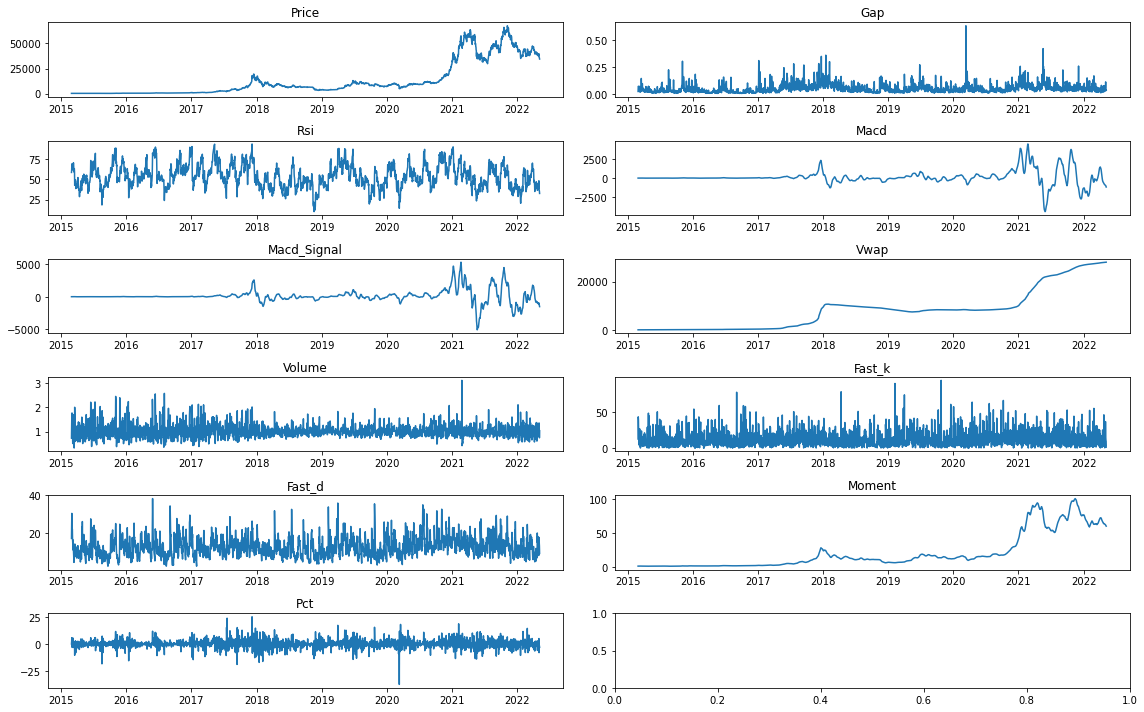

In [55]:
get_rows = lambda x: x // 2 if x % 2 == 0 else x // 2 +1 #행의 수를 결정한다.
rows = get_rows(len(df.columns))
fig, axes = plt.subplots(rows, 2, figsize=(16,10))
for i, c in enumerate(df.columns, start=1):
        plt.subplot(len(df.columns) // 2 + 1,2,i)
        plt.plot(df[c])
        plt.title(c)
plt.tight_layout()

volume은 시간이 지남에 따라 상승하는 경향이 보이므로 이동평균을 통해 나눠준 값을 사용한다.</br>
거래량 = (거래량 / 지난 7일간의 이동 평균 거래량) 평균적인 거래량에 비해 얼마나 더 많이 거래가 발생했는지 확인 가능하다.</br>
가격 역시 시간이 지남에 따라 자연히 증가하므로 전일 대비 증감률을 사용한다.
 <br>위의 그래프는 모두 전처리를 진행한 이후의 결과이다.

이렇게 데이터를 변형해 줌으로써 모델은 가격이 시간이 지남에 따라 자연히 증가하는 것이 아니라 학습 할 수 있다. </br>

Volume과 Pct를 보면 동일하게 거래량과 가격에 관한 지표를 나타내지만, 선형성이 사라진 것을 확인 할 수 있다. </br>
이제 모델은 무작정 시간이 지남에 따라 값이 증가한다고 예측하지 못한다.

<AxesSubplot:>

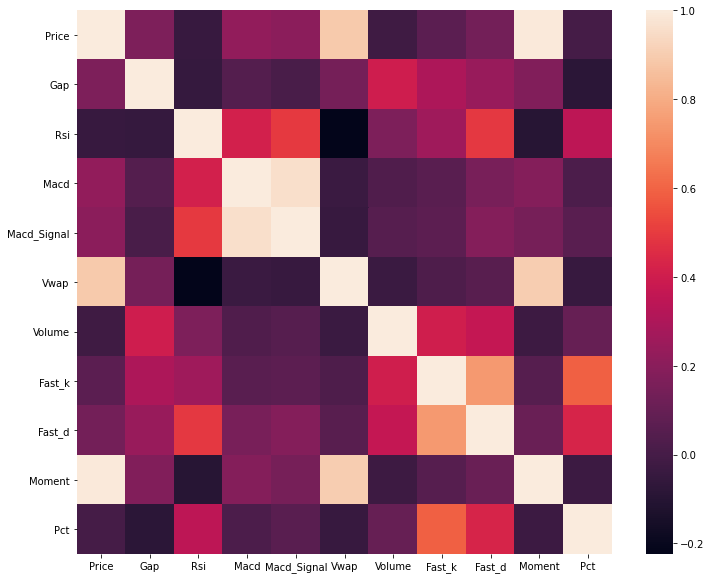

In [56]:
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr)

In [57]:
corr[corr.abs() > 0.3]

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
Price,1.000000,NaN,NaN,NaN,NaN,0.893246,NaN,NaN,NaN,0.995057,NaN
Gap,NaN,1.000000,NaN,NaN,NaN,NaN,0.401655,NaN,NaN,NaN,NaN
Rsi,NaN,NaN,1.000000,0.412446,0.496012,NaN,NaN,NaN,0.493243,NaN,0.349431
Macd,NaN,NaN,0.412446,1.000000,0.960290,NaN,NaN,NaN,NaN,NaN,NaN
Macd_Signal,NaN,NaN,0.496012,0.960290,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Vwap,0.893246,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.901938,NaN
Volume,NaN,0.401655,NaN,NaN,NaN,NaN,1.000000,0.403728,0.364885,NaN,NaN
Fast_k,NaN,NaN,NaN,NaN,NaN,NaN,0.403728,1.000000,0.746645,NaN,0.592509
Fast_d,NaN,NaN,0.493243,NaN,NaN,NaN,0.364885,0.746645,1.000000,NaN,0.430112
Moment,0.995057,NaN,NaN,NaN,NaN,0.901938,NaN,NaN,NaN,1.000000,NaN


pct는 Rsi, Fask_k와 깊은 상관성을 보인다.</br>
price는 vwap와 관련이 깊어 보인다. 

RSI와 가격 증감률 간의 상관 관계를 나타내보면 다음과 같다. </br>
어느 정도의 양의 상관 관계를 갖는 것이 보인다.

In [58]:
def plot_corr(x, y, x_name = 'X_feature', y_name = 'y_feature'):
    plt.figure(figsize=(10,10))
    x = (x - x.min()) / (x.max() - x.min())
    y = (y - y.min()) / (y.max() - y.min())
    plt.scatter(x=x, y=y)
    plt.xlabel(x_name)
    plt.ylabel(y_name)

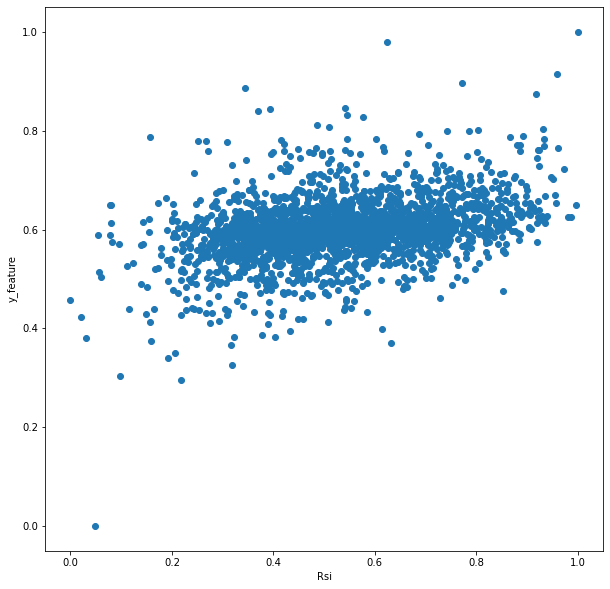

In [59]:
plot_corr(x=df['Rsi'], y=df['Pct'], x_name="Rsi")

VWAP와 가격의 상관 관계
* 강한 양의 상관 관계를 띄지만 파악이 불가한 부분이 존재한다.

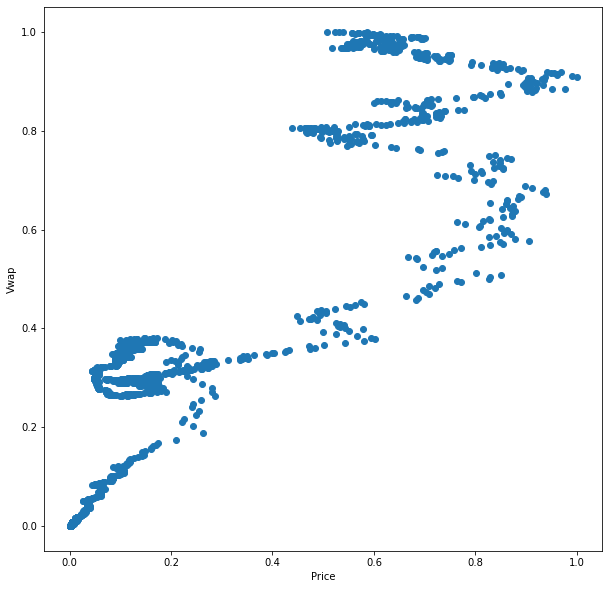

In [60]:
plot_corr(x=df['Price'], y=df['Vwap'], x_name="Price", y_name="Vwap")

#### MACD와 가격 증감률 간의 관계를 살펴보자.

MACD는 이평선의 수렴과 발산을 통해 과매수, 과매도를 보여주는 지표이다. 일반적으로 시그널선의 아래에 위치하면 과매도, 시그널 선의 위편에 위치하면 과매수 상태로 여긴다.


In [61]:
def get_cross(graph1, graph2):
    """ 특정한 그래프 2개를 입력받고 
    그래프가 교차되는 지점을 구해줍니다"""
    gap = graph1 - graph2
    buy_sign = []
    sell_sign = []
    for i, g in enumerate(gap.values[1:], start=1):
        if g * gap[i - 1] < 0:
            if g > 0: #차이가 양으로 전환되면 과매수이므로 매도 시그널이다.
                buy_sign.append(gap.index[i]) 
            else:
                sell_sign.append(gap.index[i])
    return buy_sign, sell_sign

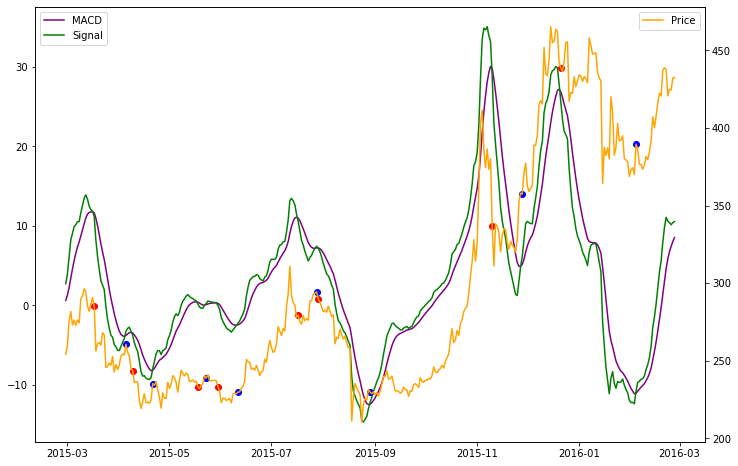

In [62]:
YEAR = 365
fig,ax1 = plt.subplots(figsize=(12,8))
macd_year, signal_year = df['Macd'].iloc[:YEAR], df['Macd_Signal'].iloc[:YEAR]
buy_point, sell_point = get_cross(macd_year, signal_year)
price = df['Price'].iloc[:YEAR]

ax1.plot(macd_year, label='MACD', color='purple')
ax1.plot(signal_year, label='Signal', color='green')
plt.legend(loc="upper left")


ax2 = ax1.twinx()
ax2.plot(price[:365],color='orange',label='Price')
ax2.scatter(buy_point, price.loc[buy_point], marker='o', color='red')
ax2.scatter(sell_point, price.loc[sell_point], marker='o', color='blue')

plt.legend(loc="upper right")

* MACD는 이동평균이라는 정보에 걸맞게 가격의 변동을 원만한 기울기로 추종하고 있다는 것을 확인 할 수 있다. </br>
* Signal과 교차되는 전략을 생각해보면 훌륭하게 들어 맞는다고 볼 수는 없을 것 같다. (빨강: 매수, 파랑: 매도)</br>


* 피쳐의 관점에선 MACD와 MACD 시그널은 실상 같은 움직임을 보이므로</br>
둘중 하나의 피쳐만 사용하는 쪽이 더 나을 듯 하다. </br>
아니면 시그널과 MACD의 격차만을 피쳐로 사용하는 것도 괜찮아 보인다.

#### 스토캐스틱 지표의 상관관계

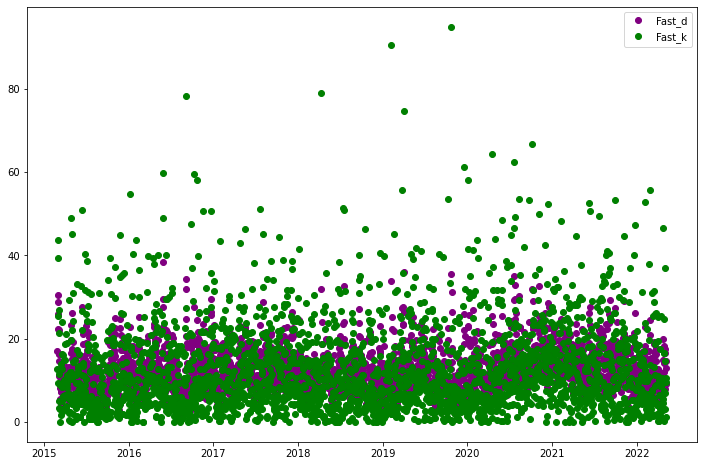

In [63]:
plt.figure(figsize=(12,8))
plt.plot(df['Fast_d'], label='Fast_d', color='purple',linestyle='None',marker='o')
plt.plot(df['Fast_k'], label='Fast_k', color='green',linestyle='None',marker='o')
plt.legend()

Fast_d는 Fast_k를 또 다시 이동평균을 내 활용한 지표이다 보니 값이 전반적으로 안정적이고 극렬하게 튀는 현상이 덜하다.</br>
Fast_k가 가격 증감률과의 상관관계도 더 높지만, 과하게 상태 변화를 받아들이는 값이라는 점에서 </br>
Fast_k보다 Fast_d를 사용하는 쪽이 유리해 보인다.</br>
Fast_k, Fast_d는 상관 계수가 0.7을 넘어가기에 하나만 사용한다.

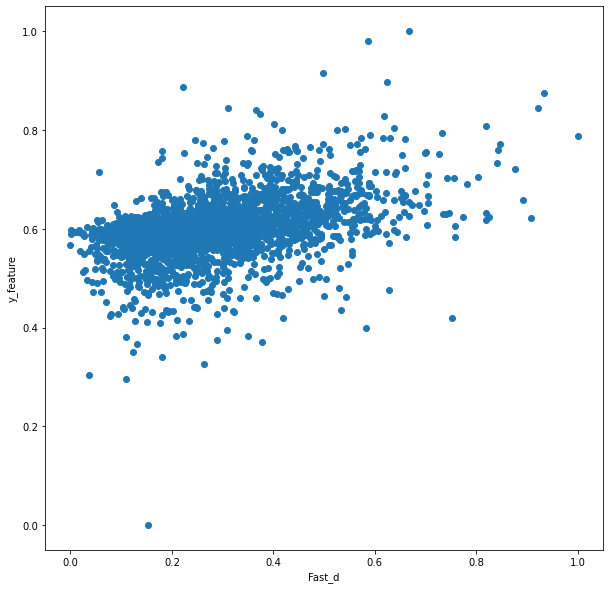

In [64]:
plot_corr(x=df['Fast_d'], y=df['Pct'],x_name="Fast_d")

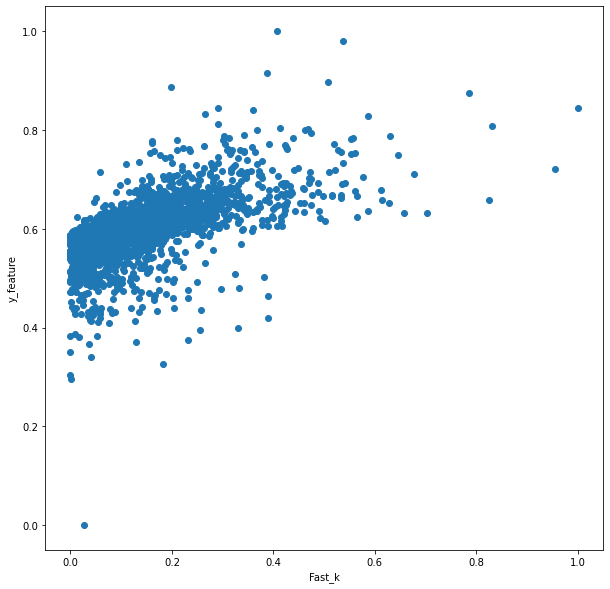

In [65]:
plot_corr(x=df['Fast_k'],y=df['Pct'],x_name="Fast_k")

#### 피쳐 선택
다음과 같은 피쳐를 제외하고 모델을 학습 시키기로 했다.
* Gap: 대신 가격 증감률을 사용하기로 했다.
* Macd, Macd_Signal: 대신 시그널 - MACD를 사용한다.
* Fast_k: 대신 Fast_d를 사용한다.

In [66]:
macd_gap = df['Macd_Signal'] - df['Macd']
new_df = df.drop(["Macd","Fast_k","Volume","Gap"], axis=1)
new_df["Macd_Gap"] = macd_gap
test_df, new_df = new_df[-100:], new_df.iloc[:-100]

#### 모멘텀 지표
* 추가적으로 특정 주기별 비트코인의 기하 평균 수익률을 기록하는 모멘텀 지표를 추가해준다.
* 모멘텀 지표를 통해 추세를 확인 할 수 있다.

In [67]:
def get_profit(X):
    """수익률을 구해준다."""
    seed = [1]
    for i, v in enumerate(X[1:], start=1):
        seed.append(seed[i - 1] * (1 + v))
    return seed

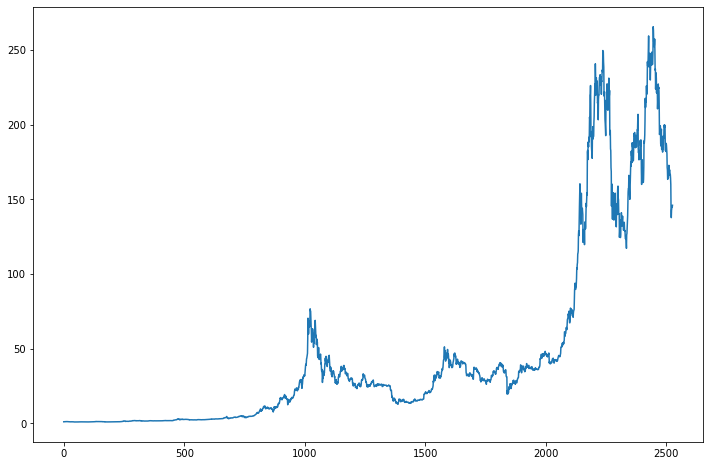

In [68]:
plt.figure(figsize=(12,8))
plt.plot(get_profit(new_df['Pct'] / 100))

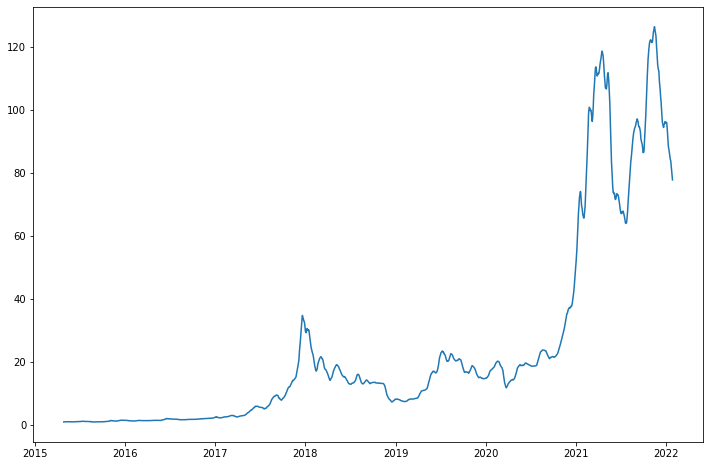

In [69]:
#수익 곡선을 그려보자 비트코인 그래프와 흡사하게 그려진다.
#모멘텀 팩터 만들기
profit = pd.Series(index=new_df.index, data=get_profit(new_df['Pct'] / 100)) #profit은 실제 내 수익률을 보여준다.
w2 = profit.rolling(14).apply(lambda x: x.prod() ** (1.0 / 14)) #2주 간의 기하 평균 수익률
m1 = profit / profit.rolling(30).apply(lambda x: x.prod() ** (1.0 / 30)) #1달 간의 기하 평균 수익률
m2 = profit / profit.rolling(60).apply(lambda x: x.prod() ** (1.0 / 60)) #2달 간의 기하 평균 수익률
momentum = (w2 * 0.5 + m1 * 0.3 + m2 * 0.2).dropna()
plt.figure(figsize=(12, 8))
plt.plot(momentum)

* 모멘텀 지표는 실제 수익률 그래프와 비교했을 때 평균을 활용하기에 훨씬 부드럽고 </br>
전반적인 추세 파악에 유용하다.

#### 이상치 확인 해보기
* iqr 범위를 벗어나는 데이터가 몇개 있는지 확인해보자. 
* gap, vwap, macd가 특히 심하다.


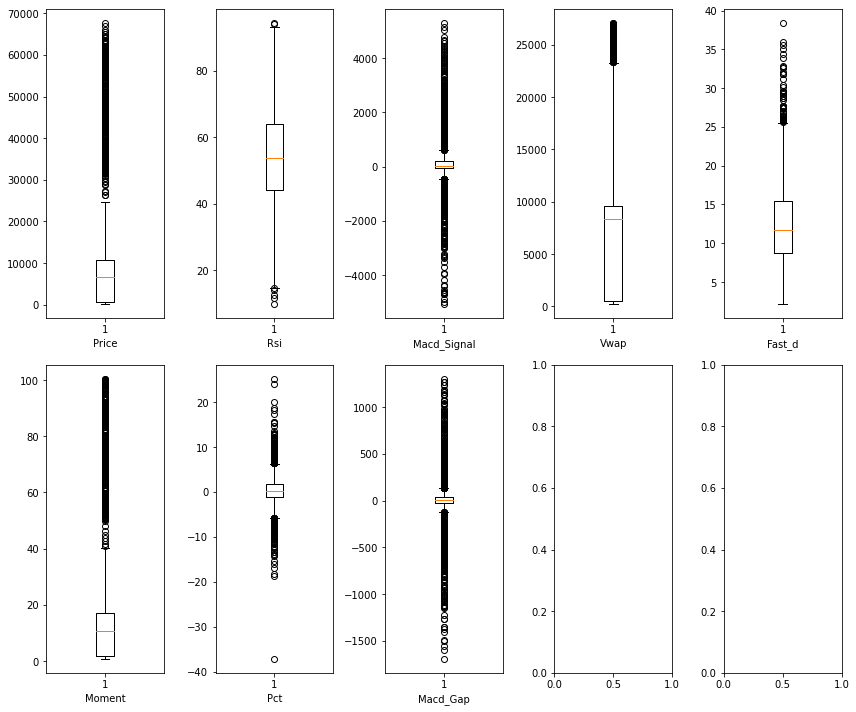

In [70]:
fig,axes = plt.subplots(2,5,figsize=(12,10))
for i, c in enumerate(new_df.columns,start=1):
    plt.subplot(2,5,i)
    plt.boxplot(new_df[c])
    plt.xlabel(c)
plt.tight_layout()

In [71]:
from collections import defaultdict
def get_outliers(df):
    """ 
        iqr 범위를 벗어나는 아웃 라이어들의 인덱스를 반환한다.
    """
    q_1 = df.apply(lambda x: np.quantile(x, 0.25))
    q_3 = df.apply(lambda x: np.quantile(x, 0.75))
    iqr = q_3 - q_1
    min_p = q_1 - 1.5 * iqr
    max_p = q_3 + 1.5 * iqr
    outliers = np.where((df < min_p) | (df > max_p))
    row, col = outliers
    outliers_loc = defaultdict(list)
    for r,c in zip(row,col):
        outliers_loc[df.columns[c]].append(r)
    return outliers_loc


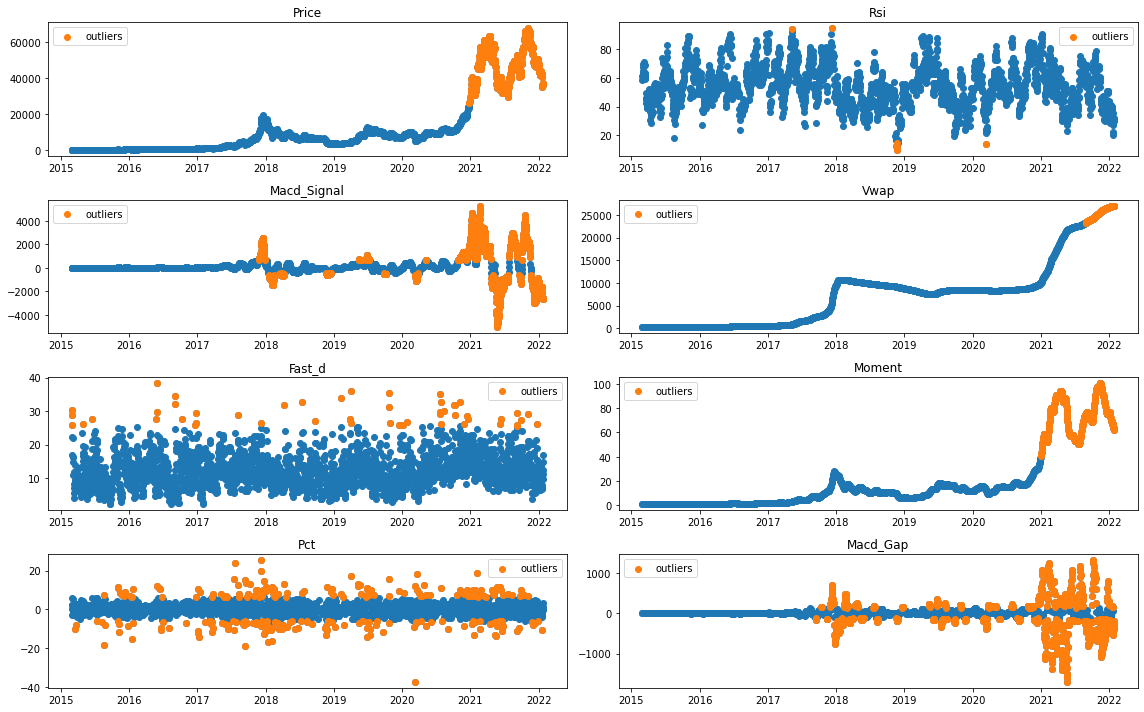

In [72]:
def draw_outlier(outliers_cols, df):
    """ 아웃 라이어들을 피쳐 별로 전부 그려 줍니다"""
    rows = get_rows(len(df.columns))
    fig, axes = plt.subplots(rows, 2, figsize=(16,10))
    for i, c in enumerate(df.columns,start=1):
        index = df[c].index
        plt.subplot(rows,2,i)
        plt.title(c)
        plt.scatter(x=index, y=df[c])
        plt.scatter(x=df[c].iloc[outliers_cols[c]].index, y=df[c].iloc[outliers_cols[c]],label='outliers')
        plt.legend()
    plt.tight_layout()

outliers_cols = get_outliers(new_df)
draw_outlier(outliers_cols, new_df)

피쳐별로 아웃라이어를 모조리 제거해 주기에는 문제가 있다. </br>
RSI에서 잡힌 아웃라이어 정도만 제거해준다.

In [73]:
for k, v in outliers_cols.items():
    print(f"{k}: {len(v)}")

Fast_d: 51
Pct: 266
Rsi: 7
Macd_Gap: 648
Macd_Signal: 583
Price: 398
Moment: 392
Vwap: 153


<AxesSubplot:>

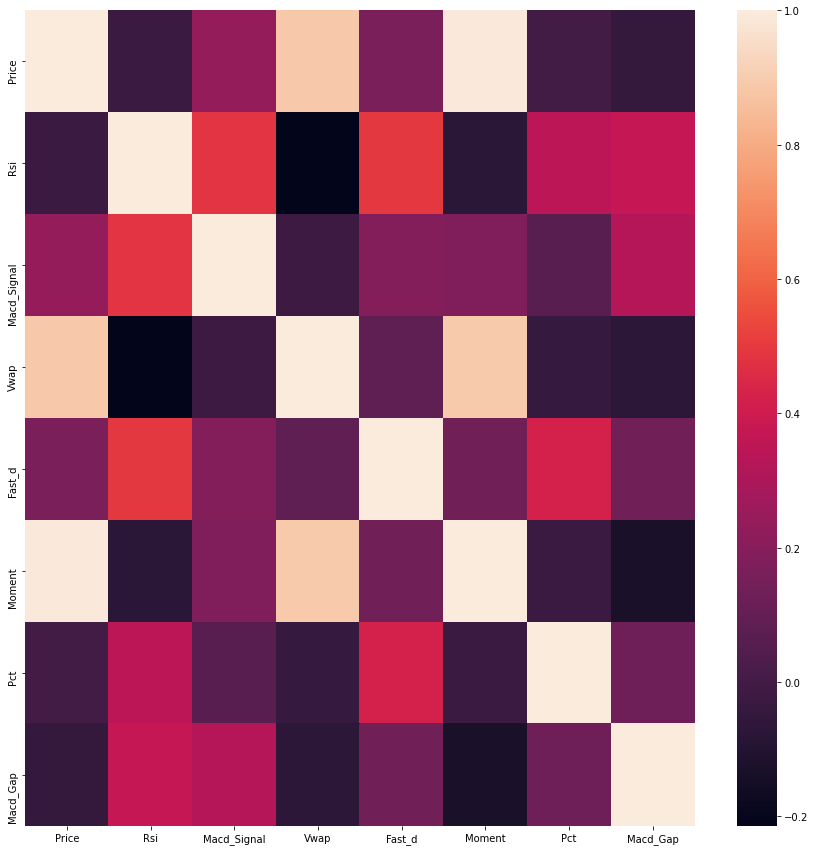

In [74]:
corr = new_df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr)

모멘트 팩터는 큰 연관성은 없어 보이지만, 전반적인 수익률 곡선의 추세를 보여주기에 사용했다.</br>
기존에 존재하는 듀얼 모멘텀 전략 등에서의 아이디어를 활용할 수는 없을까? 라는 가정에서 출발했다.</br>
모멘트 팩터는 실상 조금 완만한 가격 데이터라 해도 과언이 아니다.

모델을 생성하고 비교해보자.

In [75]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=False)),
    ('min_max', MinMaxScaler()),
    ('regulator', Ridge(alpha=10,solver="cholesky", random_state=42, fit_intercept=True, max_iter=2000))
])

lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=True)),
    ('min_max', MinMaxScaler()),
    ('regulator', Lasso(alpha=10, random_state=42, fit_intercept=True, max_iter=2000))
])

elastic_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=True)),
    ('min_max', MinMaxScaler()),
    ('regulator', ElasticNet(alpha=10, random_state=42, fit_intercept=True, max_iter=2000, l1_ratio=0.8))
])

rf_model = Pipeline([
    ('min_max',MinMaxScaler()),
    ('machine',RandomForestRegressor(bootstrap=True, random_state=42, oob_score=True, max_depth=2000))
])

In [76]:
def create_train_data(df):
    """ 트레이닝 데이터를 생성한다. 
        다음날 데이터를 예측 해야 하므로 한 칸씩 미뤄주고 댕겨준다.
    """
    X = df.drop(['Price'], axis=1).iloc[:-1]
    y = df['Price'].iloc[1:]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)
    return train_X, test_X, train_y, test_y

In [77]:
train_X, test_X, train_y, test_y = create_train_data(new_df)
ridge_model.fit(train_X, train_y)
lasso_model.fit(train_X, train_y)
elastic_model.fit(train_X, train_y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=1)),
                ('min_max', MinMaxScaler()),
                ('regulator',
                 ElasticNet(alpha=10, l1_ratio=0.8, max_iter=2000,
                            random_state=42))])

In [78]:
def plot_coef(coef, index, intercept=False):
    if intercept:
        index = index.insert(0, "Intercept")
    coef_df = pd.DataFrame(data=coef,index=index,columns=["Coef"])
    coef_df.plot.bar()


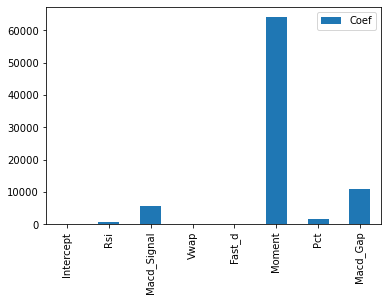

In [79]:
plot_coef(lasso_model['regulator'].coef_, train_X.columns, True)

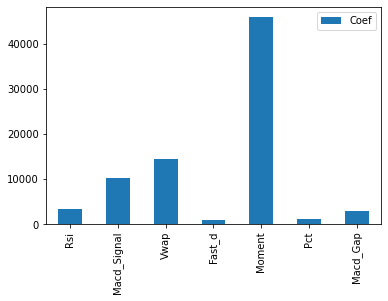

In [80]:
plot_coef(ridge_model['regulator'].coef_, train_X.columns)

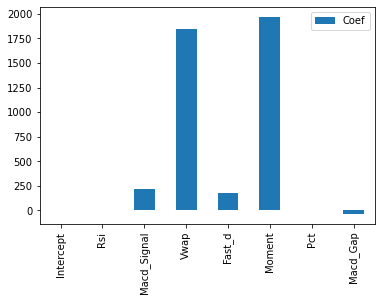

In [81]:
plot_coef(elastic_model['regulator'].coef_, train_X.columns, True)

In [82]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    """파라미터 값을 변경해가며 알파 값을 바꿔본다."""
    best_alpha = 1
    best_mse = float('inf')
    print(model['regulator'])
    for i in [1000,300,100,30,10,1,0.1,0.03]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha

ridge_model.set_params(poly_features__degree=3)
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

lasso_model.set_params(poly_features__degree=3)
l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)

elastic_model.set_params(poly_features__degree=3)
e_alpha = find_best_alpha(train_X, train_y, test_X, test_y, elastic_model)
elastic_model.set_params(regulator__alpha=e_alpha)
elastic_model.fit(train_X, train_y)



Ridge(alpha=10, max_iter=2000, random_state=42, solver='cholesky')
mse: 49656155.90971638, alpha: 1000
mse: 15042338.518759592, alpha: 300
mse: 7382766.582109935, alpha: 100
mse: 4197684.297949681, alpha: 30
mse: 2181697.7489025504, alpha: 10
mse: 830738.503066377, alpha: 1
mse: 771834.2035378561, alpha: 0.1
mse: 787475.6276802716, alpha: 0.03
Lasso(alpha=10, max_iter=2000, random_state=42)
mse: 16367198.013755284, alpha: 1000
mse: 4063389.2684303727, alpha: 300
mse: 1545985.5876905848, alpha: 100
mse: 973158.017274627, alpha: 30
mse: 778487.9780138345, alpha: 10
mse: 706517.8624981546, alpha: 1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 268701129.41990143, tolerance: 48100923.30774161
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 433740894.965605, tolerance: 48100923.30774161
  model = cd_fast.enet_coordinate_descent(


mse: 799169.739808294, alpha: 0.1
mse: 845858.9706874258, alpha: 0.03
ElasticNet(alpha=10, l1_ratio=0.8, max_iter=2000, random_state=42)
mse: 238817816.38126165, alpha: 1000
mse: 234784068.28502986, alpha: 300
mse: 223764966.0384572, alpha: 100
mse: 190894553.52916208, alpha: 30
mse: 129509602.52769543, alpha: 10
mse: 17459082.31743091, alpha: 1
mse: 4566812.877440691, alpha: 0.1
mse: 2264164.4422793537, alpha: 0.03


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('min_max', MinMaxScaler()),
                ('regulator',
                 ElasticNet(alpha=0.03, l1_ratio=0.8, max_iter=2000,
                            random_state=42))])

In [83]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse:.3f}')
    plt.legend()

In [84]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)
e_pred = elastic_model.predict(test_X)

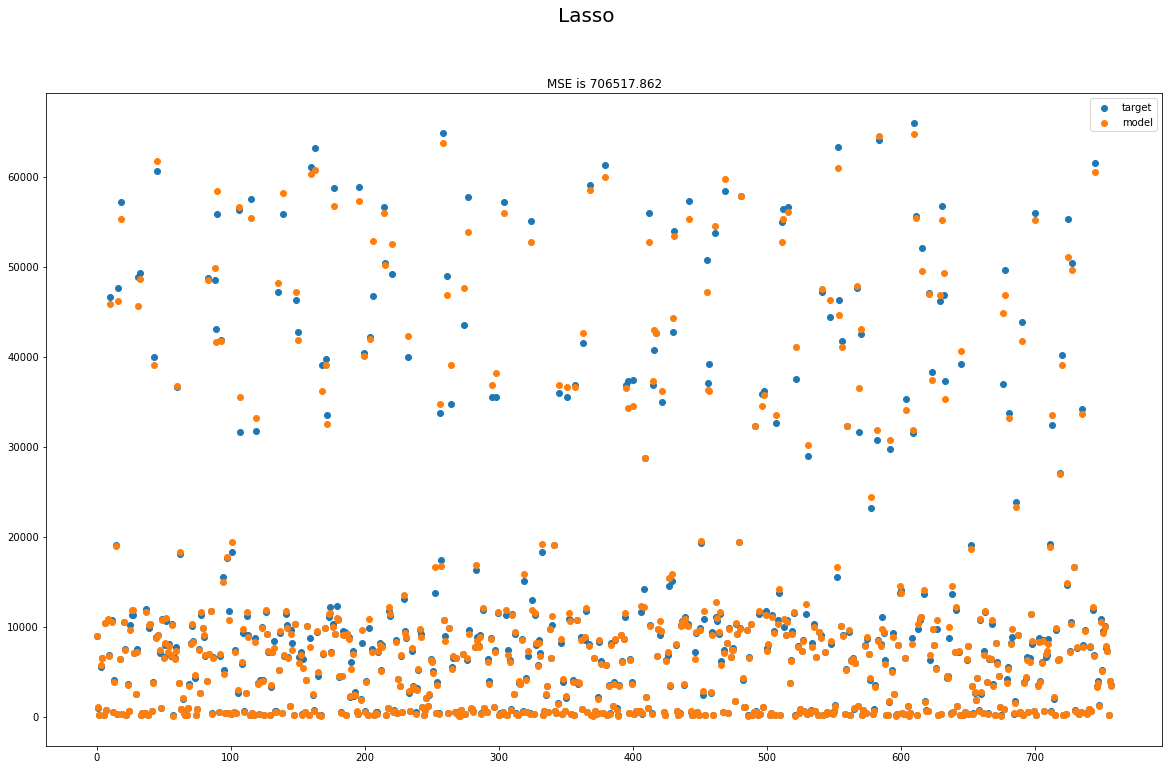

In [85]:
visualize(l_pred, test_y, "Lasso")


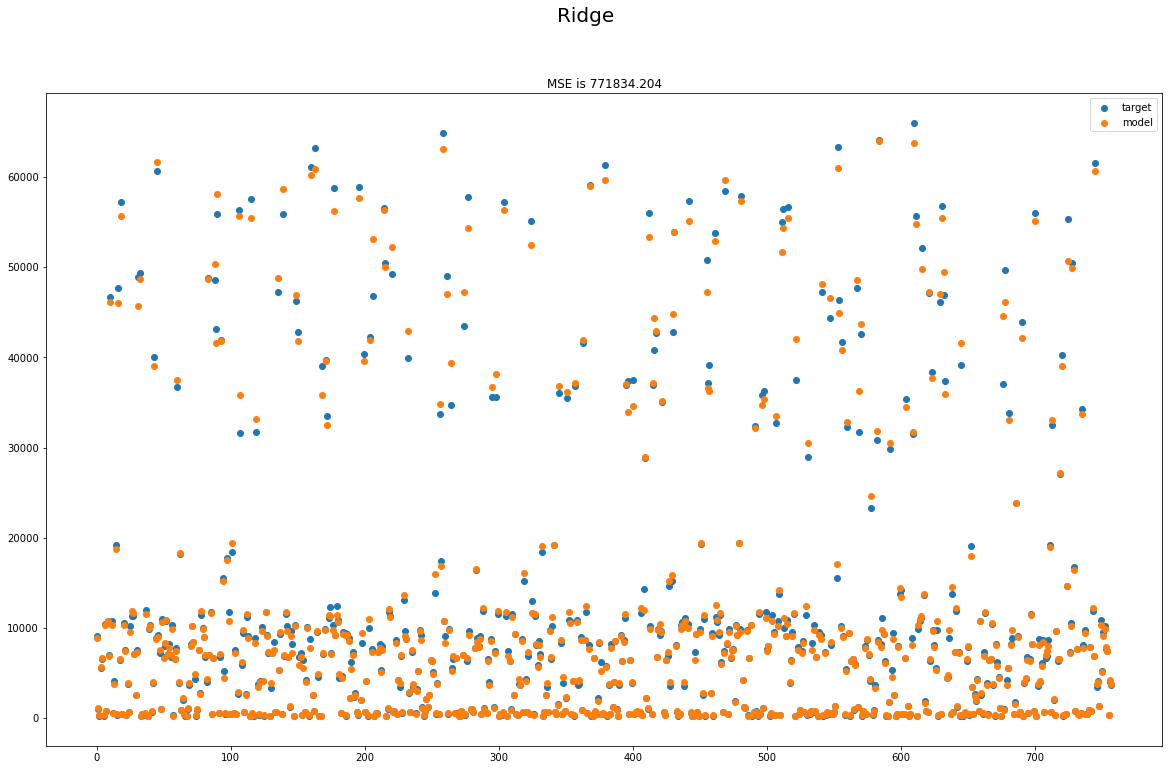

In [86]:
visualize(r_pred, test_y, "Ridge")


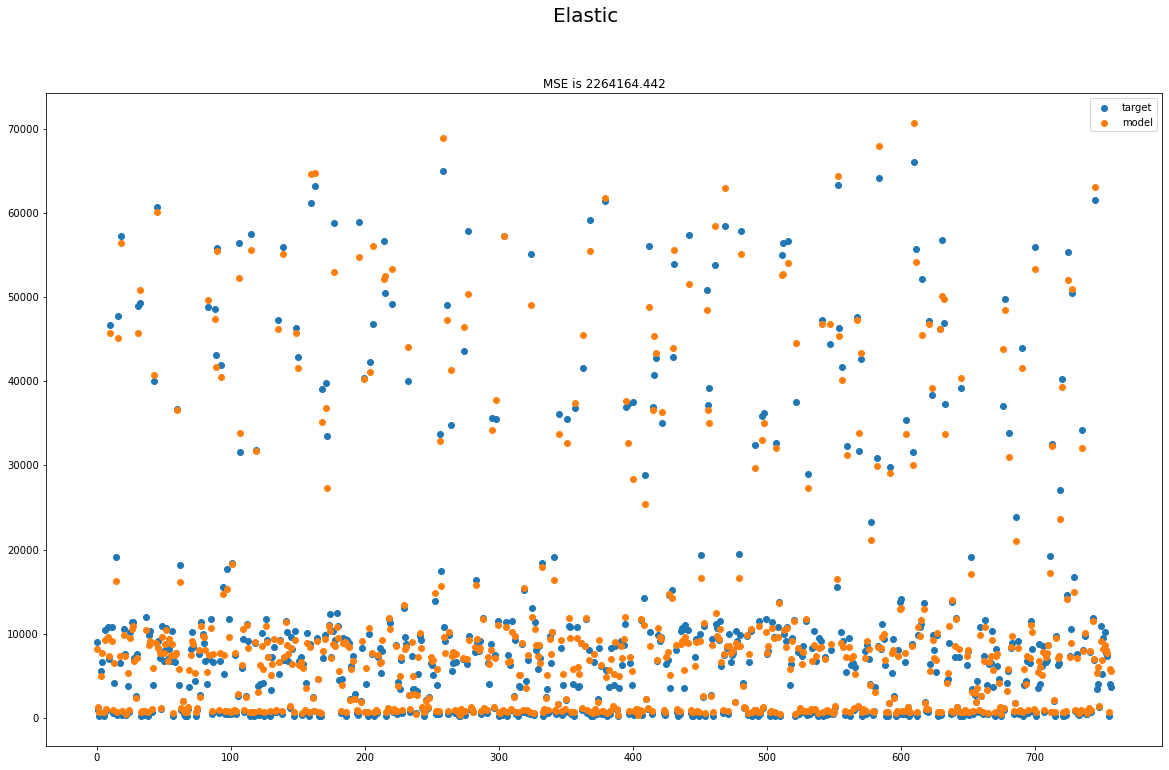

In [87]:
visualize(e_pred, test_y, "Elastic")

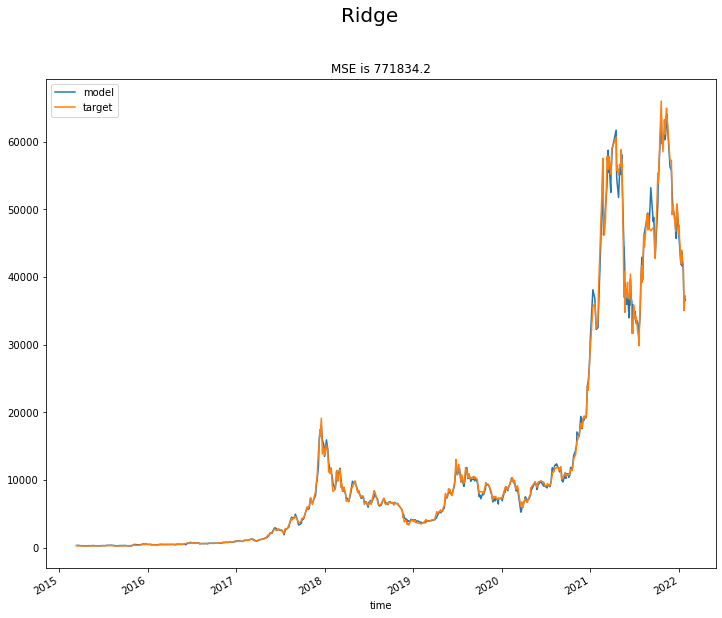

In [88]:
eval_model.visualize_plot(r_pred, test_y, "Ridge")


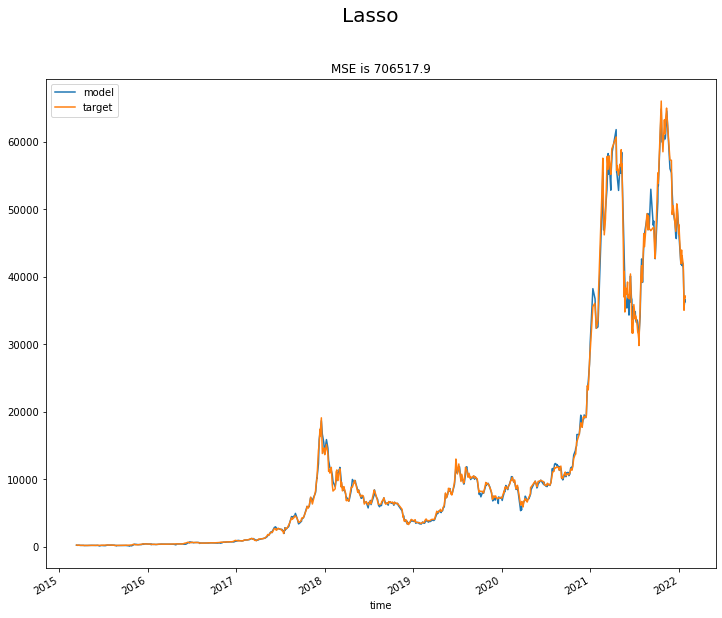

In [89]:
eval_model.visualize_plot(l_pred, test_y, "Lasso")

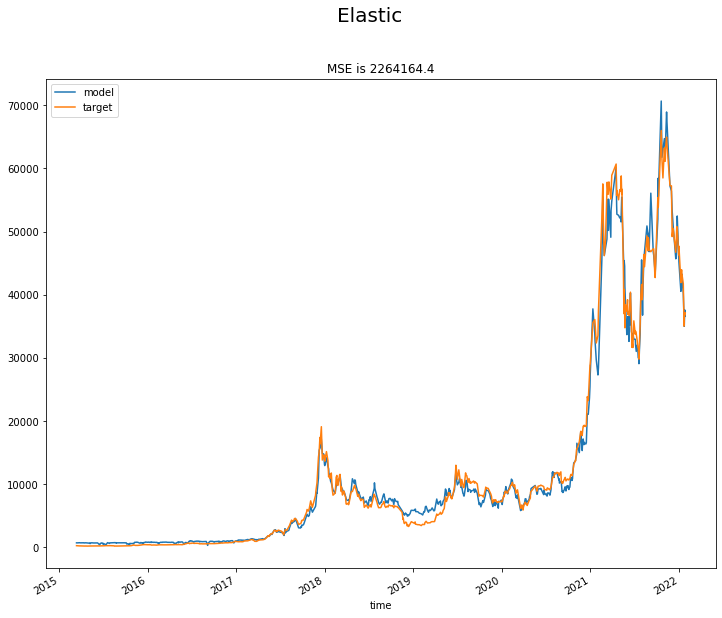

In [90]:
eval_model.visualize_plot(e_pred, test_y, "Elastic")


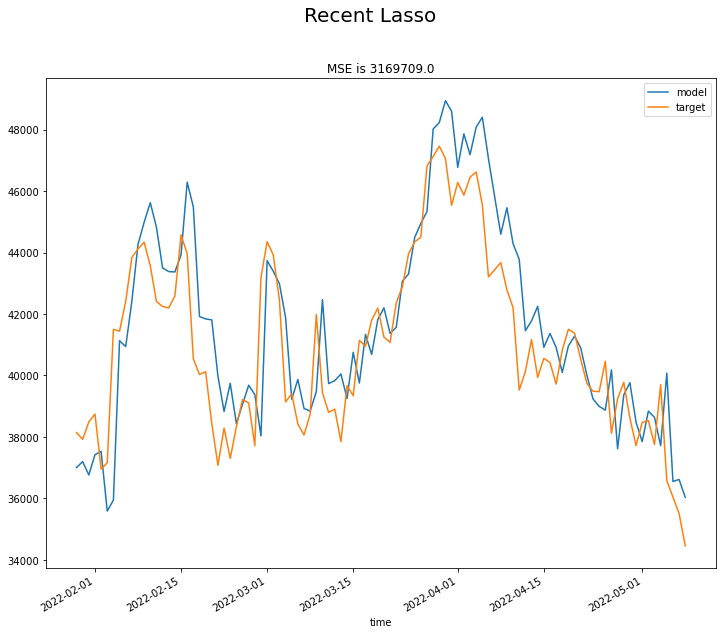

In [91]:
recent_X = test_df.drop('Price',axis=1).iloc[:-1]
recent_y = test_df['Price'].iloc[1:]
l_test_pred = lasso_model.predict(recent_X)
eval_model.visualize_plot(l_test_pred, recent_y, name="Recent Lasso")

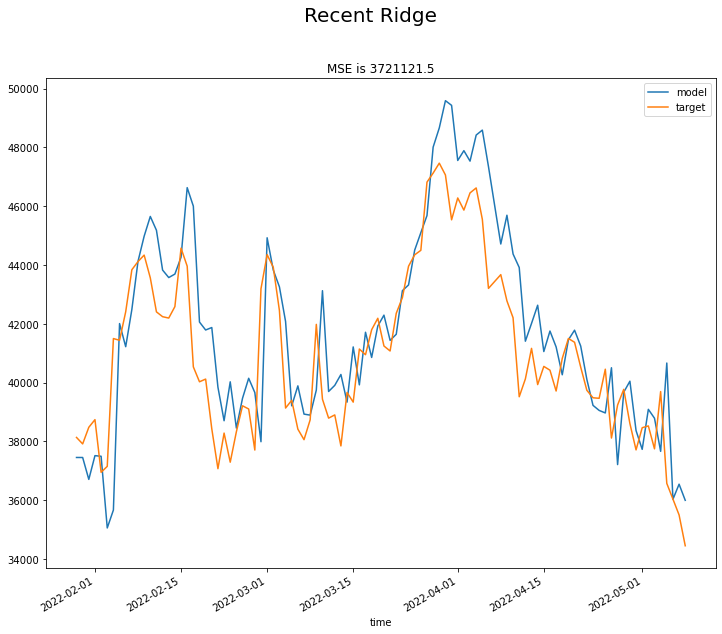

In [92]:
r_test_pred = ridge_model.predict(recent_X)
eval_model.visualize_plot(r_test_pred, recent_y, name="Recent Ridge")

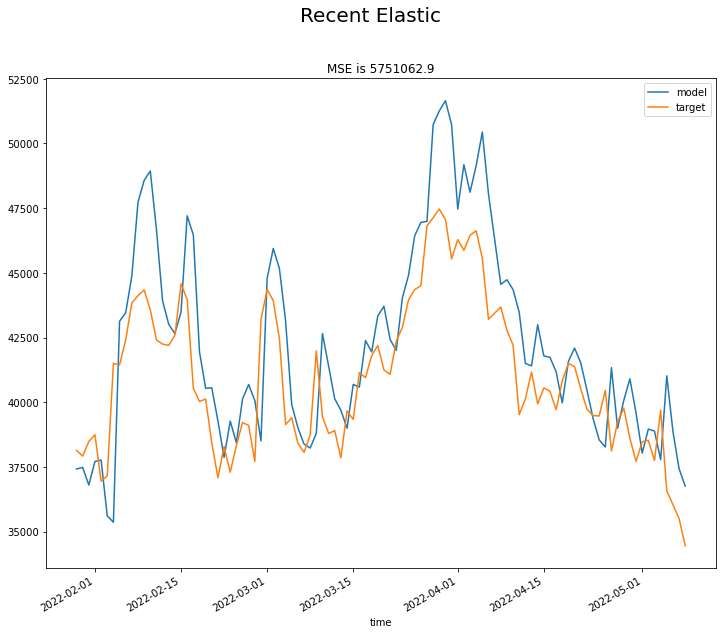

In [94]:
e_test_pred = elastic_model.predict(recent_X)
eval_model.visualize_plot(e_test_pred, recent_y, name="Recent Elastic")


### 모델
* 모델의 성능은 충격적이게도 라쏘가 가장 괜찮은 성능을 보이고 있다. 
* 실상 모맨텀 팩터 하나에만 의지하며 예측을 진행하고 있다.

In [42]:
# import joblib
# joblib.dump(lasso_model, "Lasso_BTC_only.pkl")
# joblib.dump(ridge_model, "Ridge_BTC_only.pkl")

In [95]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
tscv = TimeSeriesSplit(n_splits=20)
train_X = df.drop(['Price'], axis=1).iloc[1:]
train_y = df['Price'].iloc[:-1]
cv_result = []
for m in [ridge_model, lasso_model, elastic_model]:
    result = []
    for i, (train_index, test_index) in enumerate(tscv.split(train_X)):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        model = m.fit(X_train, y_train)
        pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, pred)
        mse = np.sqrt(mean_squared_error(y_test, pred))
        score = r2_score(y_test, pred)
        adj_score = 1 - (1 - r2_score(y_test, pred)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
        result.append([mae, mse, score, adj_score])
    cv_result.append(pd.DataFrame(data = result, columns=["mae","mse","score","adj_score"]))

/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14759039.264638871, tolerance: 245521.8936480035
  model = cd_fast.enet_coordinate_descent(


In [96]:
cv_result[0] #ridge

,mae,mse,score,adj_score
0,7.509066,14.566545,0.805760,0.788721
1,44.163904,50.821065,-0.689118,-0.837286
2,10.289528,17.023634,0.974303,0.972048
3,13.321445,15.080173,0.883233,0.872990
4,28.141972,38.420680,0.944144,0.939245
5,738.241110,1049.477185,-1.731336,-1.970927
6,311.871479,457.175854,0.905883,0.897627
7,2925.463303,3716.028986,-0.455408,-0.583075
8,375.779627,504.200500,0.754594,0.733067
9,158.057951,195.115826,0.945149,0.940337


In [97]:
cv_result[1] #lasso

,mae,mse,score,adj_score
0,8.661059,11.982833,0.868555,0.857024
1,37.893950,41.565810,-0.129913,-0.229028
2,52.692694,74.260919,0.511002,0.468108
3,29.287444,32.408142,0.460717,0.413412
4,42.563462,54.020827,0.889577,0.879891
5,357.870087,494.408460,0.393821,0.340647
6,184.837269,236.003918,0.974919,0.972719
7,4334.973546,5712.398091,-2.439248,-2.740936
8,683.818296,907.498379,0.204993,0.135256
9,159.030042,245.549285,0.913128,0.905508


In [98]:
cv_result[2] #elastic

,mae,mse,score,adj_score
0,9.323931,20.235453,0.625154,0.592273
1,26.382693,32.512169,0.308703,0.248063
2,44.731664,57.336980,0.708488,0.682917
3,57.612165,62.912790,-1.032291,-1.210563
4,73.649442,98.449738,0.633253,0.601082
5,873.330373,1315.892111,-3.294075,-3.670749
6,869.020259,1082.754018,0.472090,0.425782
7,11376.327000,12620.729638,-15.787864,-17.260484
8,1104.351554,1472.054970,-1.091834,-1.275328
9,248.103874,320.343772,0.852146,0.839176


In [100]:
for i,(tr,te) in enumerate(tscv.split(train_X)):
    if i == 7 or i == 16 or i == 17:
        print(train_X.iloc[te])

              Gap     Rsi     Macd  Macd_Signal       Vwap  Volume  Fast_k  \
time                                                                         
2017-11-25  0.073  70.986  499.646      570.825   4026.099   1.079  18.331   
2017-11-26  0.085  74.895  527.569      639.259   4086.313   1.257  15.086   
2017-11-27  0.050  77.806  566.956      724.503   4152.406   1.211  13.872   
2017-11-28  0.040  79.093  614.007      802.215   4228.865   1.279   9.238   
2017-11-29  0.200  75.745  659.282      840.381   4371.607   1.898   6.625   
...           ...     ...      ...          ...        ...     ...     ...   
2018-03-25  0.028  41.617 -419.848     -392.091  10448.709   0.783   1.838   
2018-03-26  0.077  38.931 -417.496     -408.087  10441.063   1.035  13.896   
2018-03-27  0.056  35.673 -423.195     -445.993  10433.338   0.964   1.826   
2018-03-28  0.040  37.491 -430.740     -460.921  10426.313   0.910   8.166   
2018-03-29  0.129  31.303 -450.649     -530.286  10415.315   1.1